In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir
import uproot
import root_pandas
%load_ext jupyternotify

Welcome to JupyROOT 6.27/01


<IPython.core.display.Javascript object>

In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon,ThetaPQ ):## '__init__' is the constructor of the class
        self.virtual_photon = virtual_photon
        Nu = virtual_photon.E()   ##components of a 4-vector TLorentzVector
        Q2 = -virtual_photon.M2() ## magnitud squared of a 4-vector TLorentzVector
        self.proton = ROOT.TLorentzVector()  ## proton is an attribute of the class 'particle' just created.
        self.proton.SetPxPyPzE(0,0,0, 0.938)  ## SetPxPyPzE is just a function of ROOT
        self.W = (virtual_photon + self.proton).M() ##.M() return the magnitud of a TLorentzVector [W2=(p+q)2]
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect())) ## sign returns -1 0 or 1 if the input is negative, zero or positive.
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition, virtual photon
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        self.LorentzVector = fourvector #hadron four-vector. 4-vector is an input of this class
        self.PhiLab = self.LorentzVector.Phi()
        self.ThetaLab = self.LorentzVector.Theta()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star) # y is rapidity
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan2(self.Pt,self.Pl)
        self.P = np.sqrt(self.LorentzVector.Px()**2+self.LorentzVector.Py()**2+self.LorentzVector.Pz()**2)
      
    def redefine(self, new_virtual_photon):
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = new_virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = new_virtual_photon.Vect().Cross(self.LorentzVector.Vect()).Unit()
        sign  = np.sign(part1.Dot(self.LorentzVector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2)) 
        self.Pt = self.LorentzVector.Vect().Perp(new_virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.LorentzVector.Vect().Dot(new_virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.virtual_photon = new_virtual_photon
        
        return
        
    def print_properties(self):
        print ('Hello, let me introduce myself, i am particle pid = ' , self.pid, ' with index ', self.index, ', from event  #', self.ievt, ' Nu and W', self.Nu, ' ' , self.W)
        print ('zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y)
        print ('pid = ' , self.pid)       
        
    

In [3]:
def getDataframes(filename, Target=1,maxevents=1e9,tree_name='ntuple_data',isMC=False,
                  keepH1FailRecon=False,keepH2FailRecon=False, h2CutsTruth=False,
                 keepEFailRecon=False, makeTriggerTuple=True,includeRunNumber=False):
    dphi = np.array([])  
    include_truth=isMC
    ParticlesFromPrevious = []
    
    try:
        myfile = TFile.Open('%s'%filename,'READ')
        myfile.Print()
    except:
        print("could not open file")
    mytree = myfile.Get(tree_name)
        
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    
    tupla = {}  
    tupla['dphi'] = [] 
    tupla['dphi_lab'] = []
    tupla['drap'] = []
    tupla['h1_z'] = [] 
    tupla['h2_z'] = []
    tupla['h1_cm_pt'] = []
    tupla['h2_cm_pt'] = []
    tupla['h1_xf'] = []
    tupla['h2_xf'] = []
    tupla['h1_rap'] = []
    tupla['ycm'] = []
    tupla['h2_rap'] = []
    tupla['h1_pid'] = []
    tupla['h2_pid'] = []
    tupla['h1_cm_ph'] = []
    tupla['h2_cm_ph'] = []
    tupla['h1_cm_th'] = []  
    tupla['h2_cm_th'] = []  
    tupla['pair_mass'] = []
    tupla['pair_pt'] = []
    tupla['mx_eh1h2x'] = []
    tupla['mx_eh1x'] = []
    tupla['mx_eh2x'] = []
    tupla['t']  = []
    tupla['Q2'] = [] 
    tupla['nu'] = []
    tupla['W']  = []
    tupla['e_px'] = [] 
    tupla['e_py'] = []
    tupla['e_pz']  = []
    tupla['e_p'] = [] 
    tupla['e_ph'] = []
    tupla['e_th']  = []
    tupla['SampFracEl25'] = []
    tupla['SampFracEl20'] = []
    tupla['TargTypeSM'] = [] ## RD's vertex cuts
    tupla['TargType'] = []   ## Taisiya's vertex cuts (nominal)
    tupla['x'] = [] ## bjorken x
    tupla['u']  = []
    tupla['h1_ph'] = []
    tupla['h1_th'] = []
    tupla['h2_ph'] = []
    tupla['h2_th'] = []
    tupla['h1_p'] = []
    tupla['h2_p'] = []
    tupla['h1_deltaZ'] = []
    tupla['h2_deltaZ'] = []
    tupla['h1_Nphe'] = []
    tupla['h2_Nphe'] = []
    tupla['h1_Sector'] = []
    tupla['h2_Sector'] = []
    tupla['h1_FidCut'] = []
    tupla['h2_FidCut'] = []
    tupla['h1_FidCutPiPlus'] = []
    tupla['h2_FidCutPiPlus'] = []
    tupla['h1_Chi2CC'] = []
    tupla['h2_Chi2CC'] = []
    tupla['h1_StatCC'] = []
    tupla['h2_StatCC'] = []
    tupla['h1_Betta'] = []
    tupla['h2_Betta'] = []
    tupla['h1_T4'] = []
    tupla['h2_T4'] = []    
    tupla['evnt']  = []
    if keepH2FailRecon:
        tupla['pass_recon'] = []
    if not isMC:
        tupla['run'] = []

    #mc truth variables (added by Sebouh)
    if include_truth:
        tupla['dphi_truth'] = [] 
        tupla['dphi_lab_truth'] = []
        tupla['drap_truth'] = []
        tupla['h1_truth_z'] = [] 
        tupla['h2_truth_z'] = []
        tupla['h1_truth_cm_pt'] = []
        tupla['h2_truth_cm_pt'] = []
        tupla['h1_truth_xf'] = []
        tupla['h2_truth_xf'] = []
        tupla['h1_truth_rap'] = []
        tupla['ycm_truth'] = []
        tupla['h2_truth_rap'] = []
        tupla['h1_truth_pid'] = []
        tupla['h2_truth_pid'] = []
        tupla['h1_truth_p'] = []
        tupla['h2_truth_p'] = []
        tupla['h1_truth_cm_ph'] = []
        tupla['h2_truth_cm_ph'] = []
        tupla['h1_truth_cm_th'] = []  
        tupla['h2_truth_cm_th'] = []  
        tupla['pair_mass_truth'] = []
        tupla['pair_pt_truth'] = []
        tupla['mx_eh1h2x_truth'] = []
        tupla['mx_eh1x_truth'] = []
        tupla['mx_eh2x_truth'] = []
        tupla['t_truth']  = []
        tupla['Q2_truth'] = [] 
        tupla['nu_truth'] = []
        tupla['W_truth']  = []
        tupla['x_truth'] = []
        tupla['u_truth']  = []
        tupla['h1_truth_ph'] = []
        tupla['h1_truth_th'] = []
        tupla['h2_truth_ph'] = []
        tupla['h2_truth_th'] = []
        tupla['e_truth_px'] = [] 
        tupla['e_truth_py'] = []
        tupla['e_truth_pz']  = []
        tupla['e_truth_p'] = [] 
        tupla['e_truth_ph'] = []
        tupla['e_truth_th']  = []    
    
    ## here we create another dictionary
    tupla_mix = {}
    tupla_mix['dphi'] = []
    tupla_mix['dphi_lab'] = []
    tupla_mix['drap'] = []
    tupla_mix['h1_z'] = []
    tupla_mix['h2_z'] = []
    tupla_mix['h1_cm_pt'] = []
    tupla_mix['h2_cm_pt'] = []
    tupla_mix['h1_xf'] = []
    tupla_mix['h2_xf'] = []
    tupla_mix['h1_rap'] = []
    tupla_mix['ycm'] = []
    tupla_mix['h2_rap'] = []
    tupla_mix['h1_pid'] = []
    tupla_mix['h2_pid'] = []
    tupla_mix['h1_cm_ph']   = []
    tupla_mix['h2_cm_ph'] = []
    tupla_mix['h1_cm_th'] = []
    tupla_mix['h2_cm_th'] = []
    tupla_mix['pair_mass'] = []
    tupla_mix['pair_pt'] = []
    tupla_mix['mx_eh1h2x'] = []
    tupla_mix['mx_eh1x'] = []
    tupla_mix['mx_eh2x'] = []
    tupla_mix['t']  = []
    tupla_mix['Q2'] = []
    tupla_mix['nu'] = []
    tupla_mix['W']  = []
    tupla_mix['SampFracEl25'] = []
    tupla_mix['SampFracEl20'] = []
    tupla_mix['TargTypeSM'] = [] ## RD's vertex cuts
    tupla_mix['TargType'] = []   ## Taisiya's vertex cuts (nominal)
    tupla_mix['x'] = []
    tupla_mix['u']  = []
    tupla_mix['h1_ph'] = []
    tupla_mix['h1_th'] = []
    tupla_mix['h2_ph'] = []
    tupla_mix['h2_th'] = []
    tupla_mix['dphi_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_ph_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_th_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h1_deltaZ'] = []
    tupla_mix['h2_deltaZ'] = []
    tupla_mix['h1_Nphe'] = []
    tupla_mix['h2_Nphe'] = []
    tupla_mix['h1_Sector'] = []
    tupla_mix['h2_Sector'] = []
    tupla_mix['h1_FidCut'] = []
    tupla_mix['h2_FidCut'] = []    
    tupla_mix['h1_FidCutPiPlus'] = []
    tupla_mix['h2_FidCutPiPlus'] = []       
    tupla_mix['h1_Chi2CC'] = []
    tupla_mix['h2_Chi2CC'] = []
    tupla_mix['h1_StatCC'] = []
    tupla_mix['h2_StatCC'] = []
    tupla_mix['evnt'] = []
    tupla_mix['run'] = []
    
    ## here we create another dictionary
    tupla_trigger = {}
    tupla_trigger['h1_pid'] = []
    tupla_trigger['h1_xf'] = []
    tupla_trigger['h1_xf_default'] = []
    tupla_trigger['h1_z']  = []
    tupla_trigger['h1_cm_pt'] = []
    tupla_trigger['h1_rap']  = []
    tupla_trigger['ycm'] = []
    tupla_trigger['Q2'] = []
    tupla_trigger['x'] = []
    tupla_trigger['nu'] = []
    tupla_trigger['W'] = []
    tupla_trigger['e_px'] = [] 
    tupla_trigger['e_py'] = []
    tupla_trigger['e_pz']  = []
    tupla_trigger['e_p'] = [] 
    tupla_trigger['e_ph'] = []
    tupla_trigger['e_th']  = []    
    tupla_trigger['SampFracEl25'] = []
    tupla_trigger['SampFracEl20'] = []
    tupla_trigger['TargTypeSM'] = [] ## RD's vertex cuts
    tupla_trigger['TargType'] = []   ## Taisiya's vertex cuts (nominal)
    tupla_trigger['h1_cm_ph'] = []
    tupla_trigger['h1_cm_th'] = []
    tupla_trigger['TargType'] = []
    tupla_trigger['missing_mass'] = []
    tupla_trigger['h1_ph'] = []
    tupla_trigger['h1_th'] = []
    tupla_trigger['h1_deltaZ'] = []
    tupla_trigger['h1_Nphe'] = []
    tupla_trigger['h1_Sector'] = []
    tupla_trigger['h1_FidCut'] = []
    tupla_trigger['h1_FidCutPiPlus'] = []
    tupla_trigger['h1_Chi2CC'] = []
    tupla_trigger['h1_StatCC'] = []
    tupla_trigger['h1_T4'] = []
    tupla_trigger['evnt'] = []
    if not isMC:
        tupla_trigger['run'] = []
    
    if include_truth:
        mytree.mc_W = 0.938**2+mytree.mc_Nu*0.938*2-mytree.mc_Q2
        
    
    start = time.time()
    print('About to loop over ', mytree.GetEntries() , ' entries')
    for ievt  in range(mytree.GetEntries()):
        
        #print('evnt: ',ievt, 'len ParticlesFromPrevious ', (len(ParticlesFromPrevious)))
        
        #for kkk  in range (len(ParticlesFromPrevious)):
        #    print('evnt',ievt, 'ParticlesFromPrevious, pid:', ParticlesFromPrevious[kkk].pid, 'zh: ', 
                   #ParticlesFromPrevious[kkk].Zh, 'W: ',ParticlesFromPrevious[kkk].W )
        #if len(mytree.FidCheckCut) != len(mytree.Sector):
        #    print('This shouldn\'t ever happen: len(mytree.FidCheckCut) != len(mytree.Sector). Skipping event')
        #    continue
            
        mytree.GetEntry(ievt)   
        if (mytree.W<2.05 or mytree.Q2<1.0) and not keepEFailRecon : continue
            
        if keepEFailRecon and (mytree.mc_Q2<1.0 and mytree.Q2<1.0 or \
                               mytree.W<2.05 and .9383**2+2*.9383*mytree.mc_Nu-mytree.mc_Q2<2.05 or\
                               mytree.mc_Nu>4.2):
            continue
        #if mytree.Q2<1 :
        #    print(mytree.Q2, mytree.mc_Q2)
        
        # by default we apply the loose vertex cuts (Hayk's) The other cases remains as variables
        if ievt>maxevents: break        
        if(mytree.TargTypeHH==1) :
            TargType=1
        elif(mytree.TargTypeHH==2):
            TargType=2
        else:
            TargType=0
        #print (TargType,  ' ' , Target)
        if not(isMC) and (TargType!=Target): continue ## 'Target' is a argument of this function
                
        #print('PASO all cuts')
        W = mytree.W
        Nu = mytree.Nu
        #get electron momentum:
        Pe = np.sqrt(mytree.Pex*mytree.Pex + mytree.Pey*mytree.Pey+ mytree.Pez*mytree.Pez)
        scattered_e = ROOT.TLorentzVector()
        scattered_e.SetPxPyPzE(mytree.Pex, mytree.Pey, mytree.Pez, Pe)
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        virtual_photon  = incoming_e - scattered_e 
        virtual_photon_unitvector = virtual_photon.Vect().Unit()
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        
        
        if include_truth:
            Nu_truth = mytree.mc_Nu
            Pe_truth = np.sqrt(mytree.mc_Pex*mytree.mc_Pex + mytree.mc_Pey*mytree.mc_Pey+ mytree.mc_Pez*mytree.mc_Pez)
            scattered_e_truth = ROOT.TLorentzVector()
            scattered_e_truth.SetPxPyPzE(mytree.mc_Pex, mytree.mc_Pey, mytree.mc_Pez, Pe_truth)
            virtual_photon_truth  = incoming_e - scattered_e_truth 
            virtual_photon_unitvector_truth = virtual_photon_truth.Vect().Unit()
        run=0
        if not isMC:
            if includeRunNumber:
                run = mytree.run
            else : run = -1
        ## for each event the particles are saved in the 'particles' list.        
        particles = []  ## this is how you define a list in python, this is created for each event
        #print (' Entering main loop over particles')
        for i in range(len(mytree.pid)):
            #print(mytree.pid[i])
            ## when the condition is true the 'continue' statement
            ## takes me to the next iteration of the loop
            
            if not keepH1FailRecon:
            
                if (abs(mytree.pid[i]) !=211 and mytree.pid[i]!=2212): continue 

                ## aplying the rest of cuts:
                if ( mytree.P[i]<0.2 or mytree.ThetaLab[i]<10 or mytree.ThetaLab[i]>120 ):    continue
                if ( mytree.pid[i]!=211) : continue #only leading pi+ in this analysis
                if ( mytree.pid[i]==211  and mytree.P[i]>=3.0 and 
                    (mytree.Nphe[i]<10 or mytree.Chi2CC[i]>0.0872 
                     or mytree.StatCC[i]<=0 or mytree.NRowsCC[i]==0) ):    continue     
            else:
                if mytree.mc_pid[i] !=211 and mytree.pid[i] !=211: continue 

            #print(mytree.pid[i])
            i_lv = ROOT.TLorentzVector()    ## 4-vector of the hadron
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.Zh[i]*Nu) 
            ## this is the 4-vector of the hadron
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i] ) 
            
            if include_truth:
                i_lv_truth = ROOT.TLorentzVector()    ## 4-vector of the hadron
                i_lv_truth.SetPxPyPzE(mytree.mc_Px[i],mytree.mc_Py[i],mytree.mc_Pz[i],mytree.mc_Zh[i]*Nu_truth) ## this is the 4-vector of the hadron
                i_part_truth = particle(mytree.mc_pid[i], i_lv_truth, virtual_photon_truth, mytree.mc_ThetaPQ[i] ) ## particle is the class defined previously
             
            
            
            ## particle is the class defined previously
            ## in this 'particles' list there are NO cuts applied (except the pid and obvious ones)
            particles.append(i_part)   ## save that particle in the 'particles' list
            X = (virtual_photon + proton -  i_part.LorentzVector) #unobserved hadronic system
            #print('event:',ievt,'particle i:', i,' with PID:',  i_part.pid, 'and Zh:',
            #       i_part.Zh, ', W: ',i_part.W)
            if i_part.Zh > 0.5 or keepH1FailRecon and i_part_truth.Zh>0.5: #only save triggers and do correlations if they have z>0.5
            #if i_part.Pt>1.0: #only save triggers if pT>1.0 
            ## HERE WE SAVE THE VARIABLES FOR THE TRIGGER PARTICLE (THE ONE WITH Zh>0.5)
                e_p = np.sqrt(mytree.Pex**2+mytree.Pey**2+mytree.Pez**2)
                e_ph = np.arctan2(mytree.Pey,mytree.Pex)
                e_th = np.arctan2(np.sqrt(mytree.Pex**2+mytree.Pey**2),mytree.Pez)
                if makeTriggerTuple:
                    tupla_trigger['h1_pid'].append(i_part.pid)
                    if not isMC:
                        tupla_trigger['run'].append(run)
                    tupla_trigger['h1_xf'].append(i_part.Xf)
                    tupla_trigger['h1_xf_default'].append(-1)
                    tupla_trigger['h1_z'].append(i_part.Zh)
                    tupla_trigger['h1_cm_pt'].append(i_part.Pt)
                    tupla_trigger['h1_rap'].append(i_part.y_star)
                    tupla_trigger['ycm'].append(i_part.ycm)
                    tupla_trigger['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla_trigger['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla_trigger['missing_mass'].append(X.M())
                    tupla_trigger['Q2'].append(mytree.Q2)
                    tupla_trigger['x'].append(mytree.Xb)
                    tupla_trigger['nu'].append(mytree.Nu)
                    tupla_trigger['W'].append(mytree.W)
                    tupla_trigger['e_px'].append(mytree.Pex)
                    tupla_trigger['e_py'].append(mytree.Pey)
                    tupla_trigger['e_pz'].append(mytree.Pez)
                    tupla_trigger['e_p'].append(e_p)
                    tupla_trigger['e_ph'].append(e_ph)
                    tupla_trigger['e_th'].append(e_th)
                    tupla_trigger['h1_T4'].append(mytree.T4[i])
                    tupla_trigger['SampFracEl25'].append(mytree.SampFractionEl25)
                    tupla_trigger['SampFracEl20'].append(mytree.SampFractionEl20)
                    tupla_trigger['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                    tupla_trigger['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                    tupla_trigger['h1_ph'].append(mytree.PhiLab[i])
                    tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                    #print 'mytree.Pt[i] ' , mytree.Pt[i], ' check: ' ,i_part.Vector.Perp(virtual_photon_unitvector)

                    #print('Testing theta PQ', mytree.ThetaPQ[i],  ' '  , 180.0*i_part.ThetaPQ/np.pi)
                    #print('Testing phi PQ', mytree.PhiPQ[i],  ' '  , 180.0*i_part.PhiPQ/np.pi),Nphe,deltaZ
                    tupla_trigger['h1_deltaZ'].append(mytree.deltaZ[i])
                    tupla_trigger['h1_Nphe'].append(mytree.Nphe[i])
                    tupla_trigger['h1_Sector'].append(mytree.Sector[i])
                    tupla_trigger['h1_FidCut'].append(mytree.FidCheckCut[i])
                    tupla_trigger['h1_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[i])
                    tupla_trigger['h1_Chi2CC'].append(mytree.Chi2CC[i])
                    tupla_trigger['h1_StatCC'].append(mytree.StatCC[i])
                    tupla_trigger['evnt'].append(mytree.evnt)
                
                for j in range(len(mytree.pid)): 
                    if i==j: continue
                    pass_recon=True
                    if mytree.pid[j]!=2212: pass_recon=False
                    #print('evnt', ievt,' j:', j, ' , lenpid:',len(mytree.pid) )
                    ## aplying the rest of cuts:
                    if ( mytree.P[j]<0.2 or mytree.ThetaLab[j]<10 or mytree.ThetaLab[j]>120 or mytree.pid[j] != 2212 or mytree.P[j]>3.0):    pass_recon=False
                    if not pass_recon:
                        if not keepH2FailRecon:
                            continue
                            
                        if mytree.mc_pid[j]!=2212: continue
                        
                        if h2CutsTruth:
                            #print('evnt', ievt,' j:', j, ' , lenpid:',len(mytree.pid) )
                            ## aplying the rest of cuts:
                            if ( mytree.mc_P[j]<0.2 or mytree.mc_ThetaLab[j]<10 or mytree.mc_ThetaLab[j]>120 or mytree.mc_pid[j] != 2212 or mytree.mc_P[j]>3.0):    continue
                            
                        #if ( mytree.mc_pid[j]==211  and mytree.mc_P[j]>=3.0 and 
                        #    (mytree.Nphe[j]<10 or mytree.Chi2CC[j]>0.0872 or mytree.StatCC[j]<=0 or 
                        #     mytree.NRowsCC[j]==0) ):    continue  
                    #if (SampFractionEl==0):    continue
                    #print('inside j loop')
                    
                    
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.Zh[j]*Nu)
                    j_part = particle(mytree.pid[j], j_lv, virtual_photon, mytree.ThetaPQ[j] )
                    ## particle is the defined class
                    if include_truth:
                        j_lv_truth = ROOT.TLorentzVector()    ## 4-vector of the hadron
                        j_lv_truth.SetPxPyPzE(mytree.mc_Px[j],mytree.mc_Py[j],mytree.mc_Pz[j],mytree.mc_Zh[j]*Nu_truth) ## this is the 4-vector of the hadron
                        j_part_truth = particle(mytree.mc_pid[j], j_lv_truth, virtual_photon_truth, mytree.mc_ThetaPQ[j] ) ## particle is the class defined previously
                        dphi_truth = abs(ROOT.TVector2.Phi_mpi_pi(i_part_truth.PhiPQ-j_part_truth.PhiPQ))  
                        dphi_lab_truth = abs(ROOT.TVector2.Phi_mpi_pi(i_part_truth.PhiLab-j_part_truth.PhiLab))
                        dy_truth = i_part_truth.y-j_part_truth.y
                        deta_truth = dy_truth
                        
                        dihadron_truth = i_part_truth.LorentzVector+j_part_truth.LorentzVector  ## LorentzVector is a method of the 
                                    #particle class, is the '4-vector' of the particle, 3rd argument of the class
                    
                        X_truth = (virtual_photon_truth + proton - dihadron_truth) #unobserved hadronic system
                        X1_truth = (virtual_photon_truth + proton - i_part_truth.LorentzVector)
                        X2_truth = (virtual_photon_truth + proton - j_part_truth.LorentzVector)
                    
                    
                    ## TVector2.Phi_mpi_pi is a built in function of TVector2 class (2D vectors).
                    ## Returns Phi angle in the interval [-pi,pi]. 
                    ## Also, we used the 'abs' to obtain the 0->pi range
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))  
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))
                    
                    dy = i_part.y-j_part.y  ## i_part and j_part are object of the class particles 
                                            # and 'y' is a method, is the rapidity in the lab frame
                    deta = dy
                    ## Di-hadron 4-vector, is the sum P_{di-hadron} = P_{trigger-hadron} + P_{other-hadron}
                    dipion = i_part.LorentzVector+j_part.LorentzVector  ## LorentzVector is a method of the 
                                    #particle class, is the '4-vector' of the particle, 3rd argument of the class
                    
                    X  = (virtual_photon + proton - dipion) #unobserved hadronic system
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - j_part.LorentzVector)
                    
                    ## note: drap is h1_rap - h2_rap
                    tupla['dphi'].append(dphi) ## phiPQ(i) - phiPQ(j)
                    tupla['dphi_lab'].append(dphi_lab)
                    tupla['drap'].append(dy)         ## This is in lab frame -> dy = y_lab(i) - y_lab(j)
                    tupla['h1_z'].append(i_part.Zh)
                    tupla['h2_z'].append(j_part.Zh)
                    tupla['h1_cm_pt'].append(i_part.Pt)
                    tupla['h2_cm_pt'].append(j_part.Pt)
                    tupla['h1_xf'].append(i_part.Xf)
                    tupla['h2_xf'].append(j_part.Xf)
                    tupla['h1_rap'].append(i_part.y_star)  ## y_star = y(lab) - y(cm)
                    tupla['ycm'].append(i_part.ycm)
                    tupla['h2_rap'].append(j_part.y_star)
                    tupla['h1_pid'].append(i_part.pid)
                    tupla['h2_pid'].append(j_part.pid)
                    tupla['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla['h2_cm_ph'].append(j_part.PhiPQ)
                    tupla['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla['h2_cm_th'].append(j_part.ThetaPQ)
                    tupla['pair_mass'].append(dipion.M())
                    tupla['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla['mx_eh1h2x'].append(X.M())
                    tupla['mx_eh1x'].append(X1.M())
                    tupla['mx_eh2x'].append(X2.M())
                    tupla['t'].append( -(virtual_photon- dipion).M2())
                    tupla['Q2'].append(mytree.Q2)
                    tupla['x'].append(mytree.Xb)
                    tupla['nu'].append(mytree.Nu)
                    tupla['W'].append(mytree.W)
                    tupla['SampFracEl25'].append(mytree.SampFractionEl25)
                    tupla['SampFracEl20'].append(mytree.SampFractionEl20)
                    tupla['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                    tupla['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                    tupla['u'].append(-(scattered_e-proton).M2())
                    tupla['h1_ph'].append(mytree.PhiLab[i])
                    tupla['h1_th'].append(mytree.ThetaLab[i])
                    tupla['h2_ph'].append(mytree.PhiLab[j])
                    tupla['h2_th'].append(mytree.ThetaLab[j])
                    tupla['h1_p'].append(mytree.P[i])
                    tupla['h2_p'].append(mytree.P[j])
                    tupla['h1_deltaZ'].append(mytree.deltaZ[i])
                    tupla['h2_deltaZ'].append(mytree.deltaZ[j])
                    tupla['h1_Nphe'].append(mytree.Nphe[i])
                    tupla['h1_Sector'].append(mytree.Sector[i])
                    if not isMC:
                        tupla['run'].append(run)
                    #if(len(mytree.FidCheckCut[i] )==len(mytree.FidCheckCut[i] )):
                    #    tupla['h1_FidCut'].append(mytree.FidCheckCut[i])
                    #else:
                    #    print('this should never happen:  len(mytree.FidCheckCut)!=len(mytree.FidCheckCutPiPlus)')                    
                    tupla['h1_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[i])
                    tupla['h2_Nphe'].append(mytree.Nphe[j])
                    tupla['h2_Sector'].append(mytree.Sector[j])
                    tupla['h1_FidCut'].append(mytree.FidCheckCut[i])
                    tupla['h2_FidCut'].append(mytree.FidCheckCut[j]) 
                    tupla['h2_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[j])                    
                    tupla['h1_Chi2CC'].append(mytree.Chi2CC[i])
                    tupla['h1_StatCC'].append(mytree.StatCC[i])
                    tupla['h2_Chi2CC'].append(mytree.Chi2CC[j])
                    tupla['h2_StatCC'].append(mytree.StatCC[j])
                    tupla['h1_Betta'].append(mytree.Betta[i])
                    tupla['h2_Betta'].append(mytree.Betta[j])
                    tupla['h1_T4'].append(mytree.T4[i])
                    tupla['h2_T4'].append(mytree.T4[j])
                    tupla['evnt'].append(mytree.evnt)
                    
                    tupla['e_px'].append(mytree.Pex)
                    tupla['e_py'].append(mytree.Pey)
                    tupla['e_pz'].append(mytree.Pez)
                    tupla['e_p'].append(e_p)
                    tupla['e_ph'].append(e_ph)
                    tupla['e_th'].append(e_th)
                    
                    if keepH2FailRecon:
                        tupla['pass_recon'].append(1 if pass_recon else 0)
                    
                    
                    if include_truth:
                        tupla['dphi_truth'].append(dphi_truth)
                        tupla['dphi_lab_truth'].append(dphi_lab_truth)
                        tupla['drap_truth'].append(dy_truth)
                        tupla['h1_truth_z'].append(i_part_truth.Zh)
                        tupla['h2_truth_z'].append(j_part_truth.Zh)
                        tupla['h1_truth_cm_pt'].append(i_part_truth.Pt)
                        tupla['h2_truth_cm_pt'].append(j_part_truth.Pt)
                        tupla['h1_truth_xf'].append(i_part_truth.Xf)
                        tupla['h2_truth_xf'].append(j_part_truth.Xf)
                        tupla['h1_truth_rap'].append(i_part_truth.y_star)
                        tupla['ycm_truth'].append(i_part_truth.ycm)
                        tupla['h2_truth_rap'].append(j_part_truth.y_star)
                        tupla['h1_truth_pid'].append(i_part_truth.pid)
                        tupla['h2_truth_pid'].append(j_part_truth.pid)
                        tupla['h1_truth_p'].append(i_part_truth.P)
                        tupla['h2_truth_p'].append(j_part_truth.P)
                        tupla['h1_truth_cm_ph'].append(i_part_truth.PhiPQ)
                        tupla['h2_truth_cm_ph'].append(j_part_truth.PhiPQ)
                        tupla['h1_truth_cm_th'].append(i_part_truth.ThetaPQ)
                        tupla['h2_truth_cm_th'].append(j_part_truth.ThetaPQ)
                        tupla['pair_mass_truth'].append(dihadron_truth.M())
                        tupla['pair_pt_truth'].append( dihadron_truth.Vect().Perp(virtual_photon_unitvector_truth))
                        tupla['mx_eh1h2x_truth'].append(X_truth.M())
                        tupla['mx_eh1x_truth'].append(X1_truth.M())
                        tupla['mx_eh2x_truth'].append(X2_truth.M())
                        tupla['t_truth'].append( -(virtual_photon_truth- dihadron_truth).M2())
                        
                        tupla['Q2_truth'].append(mytree.mc_Q2)
                        tupla['x_truth'].append(mytree.mc_Xb)
                        tupla['nu_truth'].append(mytree.mc_Nu)
                        tupla['W_truth'].append(mytree.mc_W)
                        tupla['u_truth'].append(-(scattered_e_truth-proton).M2())
                        tupla['h1_truth_ph'].append(mytree.mc_PhiLab[i])
                        tupla['h1_truth_th'].append(mytree.mc_ThetaLab[i])
                        tupla['h2_truth_ph'].append(mytree.mc_PhiLab[j])
                        tupla['h2_truth_th'].append(mytree.mc_ThetaLab[j])
                        tupla['e_truth_px'].append(mytree.Pex)
                        tupla['e_truth_py'].append(mytree.Pey)
                        tupla['e_truth_pz'].append(mytree.Pez)
                        e_truth_p = np.sqrt(mytree.mc_Pex**2+mytree.mc_Pey**2+mytree.mc_Pez**2)
                        e_truth_ph = np.arctan2(mytree.mc_Pey,mytree.mc_Pex)
                        e_truth_th = np.arctan2(np.sqrt(mytree.mc_Pex**2+mytree.mc_Pey**2),mytree.mc_Pez)
                        tupla['e_truth_p'].append(e_truth_p)
                        tupla['e_truth_ph'].append(e_truth_ph)
                        tupla['e_truth_th'].append(e_truth_th)
                                            
         #end loop over secondary loop    
                
                ## here we are still under the condition of Zh>0.4
                #print(ievt,i,j)
                #print('')
                for mixparticle in ParticlesFromPrevious: ## ParticlesFromPrevious is a list 
                                                          ## with 'particle' class objects
                    #print('\ninside mixparticle loop\n')
                    #print('i: ',i,'mixparticles pid:',mixparticle.pid,' zh :', mixparticle.Zh , ', W: ', 
                           #mixparticle.W, ' i_part Zh:', i_part.Zh, 'i_part.W: ',i_part.W)
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)
                    tupla_mix['h2_cm_ph_norot'].append(mixparticle.PhiPQ)
                    tupla_mix['h2_cm_th_norot'].append(mixparticle.ThetaPQ)
                    if not isMC :
                        tupla_mix['run'].append(run)
                    mixparticle.redefine(virtual_photon) 
                    #recalculates variables in this' event photon frame (not in the previous one)
                    #dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    #print 'dphi_pq after redefinition: ', dphi , ' phi_pq ', mixparticle.PhiPQ
                    
                    dipion = i_part.LorentzVector+mixparticle.LorentzVector
                    X  = (virtual_photon + proton - dipion)
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - mixparticle.LorentzVector)

                    #recalculate the phi_pq. It has to be with respect to the photon direction
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-mixparticle.PhiLab))

                    dy = i_part.y-mixparticle.y
                    deta = dy#i_part.ThetaPQ-mixparticle.ThetaPQ
                    tupla_mix['dphi'].append(dphi)
                    tupla_mix['dphi_lab'].append(dphi_lab)
                    tupla_mix['drap'].append(dy)
                    tupla_mix['h1_z'].append(i_part.Zh)
                    tupla_mix['h2_z'].append(mixparticle.Zh)
                    tupla_mix['h1_cm_pt'].append(i_part.Pt)
                    tupla_mix['h2_cm_pt'].append(mixparticle.Pt)
                    tupla_mix['h1_xf'].append(i_part.Xf)
                    tupla_mix['h2_xf'].append(mixparticle.Xf)
                    tupla_mix['h1_rap'].append(i_part.y_star)
                    tupla_mix['ycm'].append(i_part.ycm)
                    tupla_mix['h2_rap'].append(mixparticle.y_star)
                    tupla_mix['h1_pid'].append(i_part.pid)
                    tupla_mix['h2_pid'].append(mixparticle.pid)
                    tupla_mix['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla_mix['h2_cm_ph'].append(mixparticle.PhiPQ)
                    tupla_mix['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla_mix['h2_cm_th'].append(mixparticle.ThetaPQ)
                    tupla_mix['pair_mass'].append(dipion.M())
                    tupla_mix['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla_mix['mx_eh1h2x'].append(X.M())
                    tupla_mix['mx_eh1x'].append(X1.M())
                    tupla_mix['mx_eh2x'].append(X2.M())
                    tupla_mix['t'].append( -(virtual_photon- dipion).M2())
                    tupla_mix['Q2'].append(mytree.Q2)
                    tupla_mix['x'].append(mytree.Xb)
                    tupla_mix['nu'].append(mytree.Nu)
                    tupla_mix['W'].append(mytree.W)
                    tupla_mix['SampFracEl25'].append(mytree.SampFractionEl25)
                    tupla_mix['SampFracEl20'].append(mytree.SampFractionEl20)
                    tupla_mix['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                    tupla_mix['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                    tupla_mix['u'].append(-(scattered_e-proton).M2())
                    tupla_mix['h1_ph'].append(i_part.LorentzVector.Phi())
                    tupla_mix['h1_th'].append(mytree.ThetaLab[i])
                    tupla_mix['h2_ph'].append(mixparticle.LorentzVector.Phi())
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
                    tupla_mix['h1_deltaZ'].append(mytree.deltaZ[i])
                    tupla_mix['h2_deltaZ'].append(mytree.deltaZ[j])
                    tupla_mix['h1_Nphe'].append(mytree.Nphe[i])
                    tupla_mix['h1_Sector'].append(mytree.Sector[i])
                    tupla_mix['h1_FidCut'].append(mytree.FidCheckCut[i])
                    tupla_mix['h1_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[i])
                    tupla_mix['h2_Nphe'].append(mytree.Nphe[j])
                    tupla_mix['h2_Sector'].append(mytree.Sector[j])
                    tupla_mix['h2_FidCut'].append(mytree.FidCheckCut[j])
                    tupla_mix['h2_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[j])
                    tupla_mix['h1_Chi2CC'].append(mytree.Chi2CC[i])
                    tupla_mix['h1_StatCC'].append(mytree.StatCC[i])
                    tupla_mix['h2_Chi2CC'].append(mytree.Chi2CC[j])
                    tupla_mix['h2_StatCC'].append(mytree.StatCC[j])
                    tupla_mix['evnt'].append(mytree.evnt)
                    #for kk  in range (len(ParticlesFromPrevious)):
                        #print('ParticlesFromPrevious, pid:', ParticlesFromPrevious[kk].pid, 'zh: ', 
                               #ParticlesFromPrevious[kk].Zh, 'W: ',ParticlesFromPrevious[kk].W )
        #print (' Exiting main loop over particles (i loop, not over all entries)')
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    ##printing the 3 tuples to the output file
    df = pd.DataFrame(tupla)
    df_mix= None# pd.DataFrame(tupla_mix)
    df_trigger = pd.DataFrame(tupla_trigger)
    print ('Number of triggers with z>0.5,  ', df.query('h1_z>0.5').shape[0])
    print ('Number of pairs with z>0.5, '    , df_trigger.query('h1_z>0.5').shape[0]) 
    myfile.Close()
    return df, df_mix, df_trigger        
        

In [4]:
## here we defined some dictionaries ({})
df = {}
df_mc = {}

# Data files

In [6]:
%%notify
%time

df['Pb'],df['Pb_mix'], df['Pb_trigger'] = [None,None,None]
df['D_Pb'],df['D_Pb_mix'], df['D_Pb_trigger'] = [None,None,None]
df['Fe'],df['Fe_mix'], df['Fe_trigger'] = [None,None,None]
df['D_Fe'],df['D_Fe_mix'], df['D_Fe_trigger'] = [None,None,None]
df['C'],df['C_mix'], df['C_trigger'] = [None,None,None]
df['D_C'],df['D_C_mix'], df['D_C_trigger'] = [None,None,None]
#path = '/home/sebouh/di-hadron/data/P27/ca/'
path = '/home/sebouh/di-hadron/low_energy_protons/'
#path='/home/seba/'
tar='C'
import glob
Files = glob.glob(path+f"{tar}*.root") 
count=0
for name in Files:
    filename = name
    print ('done with: ', count, ' files')
    count=count+1
    if( '.root' not in name): continue 
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2) ## getDataframes is a function just created
    df[tar] = pd.concat([ df[tar], pairs])
    #df['%s_mix'%tar] = pd.concat([ df['%s_mix'%tar], pairs_mix])
    df['%s_trigger'%tar] = pd.concat([ df['%s_trigger'%tar], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1) ## getDataframes is a function just created
    df['D_%s'%tar] = pd.concat([ df['D_%s'%tar], pairs])
    #df['D_%s_mix'%tar] = pd.concat([ df['D_%s_mix'%tar], pairs_mix])
    df['D_%s_trigger'%tar] = pd.concat([ df['D_%s_trigger'%tar], trigger])
tar = "C"

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
done with:  0  files
/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root  has  29006299  entries
About to loop over  29006299  entries


/tmp/ipykernel_706141/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 1095.4606277942657 seconds
Number of triggers with z>0.5,   46028
Number of pairs with z>0.5,  218901
/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root  has  29006299  entries
About to loop over  29006299  entries


/tmp/ipykernel_706141/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 987.2522397041321 seconds
Number of triggers with z>0.5,   37893
Number of pairs with z>0.5,  304772
TFile: name=/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root, title=, option=READ


<IPython.core.display.Javascript object>

TFile: name=/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root, title=, option=READ


In [7]:

import pickle
with open(f"data_pion_proton_pairs_{tar}.pkl", "wb") as f:
    pickle.dump({a:df[a] for a in f"{tar} D_{tar} {tar}_trigger D_{tar}_trigger".split()}, f, pickle.HIGHEST_PROTOCOL)
print('end')

end


In [ ]:
#path = '/home/sebouh/di-hadron/data/P27/fe/'
path = '/home/sebouh/di-hadron/low_energy_protons/'
#path='/home/seba/'
tar='Fe'
import glob
Files = glob.glob(path+f"{tar}*.root") 
count=0
for name in Files:
    filename = name
    print ('done with: ', count, ' files')
    count=count+1
    if( '.root' not in name): continue 
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2) ## getDataframes is a function just created
    df[tar] = pd.concat([ df[tar], pairs])
    #df['%s_mix'%tar] = pd.concat([ df['%s_mix'%tar], pairs_mix])
    df['%s_trigger'%tar] = pd.concat([ df['%s_trigger'%tar], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1) ## getDataframes is a function just created
    df['D_%s'%tar] = pd.concat([ df['D_%s'%tar], pairs])
    #df['D_%s_mix'%tar] = pd.concat([ df['D_%s_mix'%tar], pairs_mix])
    df['D_%s_trigger'%tar] = pd.concat([ df['D_%s_trigger'%tar], trigger])
tar = "Fe"
import pickle
with open(f"data_pion_proton_pairs_{tar}.pkl", "wb") as f:
    pickle.dump({a:df[a] for a in f"{tar} D_{tar} {tar}_trigger D_{tar}_trigger".split()}, f, pickle.HIGHEST_PROTOCOL)
print('end')

print('end')

done with:  0  files
/home/sebouh/di-hadron/low_energy_protons/Fe_data_hadd.root  has  46201904  entries
About to loop over  46201904  entries


/tmp/ipykernel_3663448/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 1413.0588023662567 seconds
Number of triggers with z>0.5,   70123
Number of pairs with z>0.5,  263034
/home/sebouh/di-hadron/low_energy_protons/Fe_data_hadd.root  has  46201904  entries
About to loop over  46201904  entries


/tmp/ipykernel_3663448/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


In [ ]:
#path = '/home/sebouh/di-hadron/data/P27/pb/'
path = '/home/sebouh/di-hadron/low_energy_protons/'
#path='/home/seba/'
tar='Pb'
import glob
Files = glob.glob(path+f"{tar}*.root") 
count=0
for name in Files:
    filename = name
    print ('done with: ', count, ' files')
    count=count+1
    if( '.root' not in name): continue 
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2) ## getDataframes is a function just created
    df[tar] = pd.concat([ df[tar], pairs])
    #df['%s_mix'%tar] = pd.concat([ df['%s_mix'%tar], pairs_mix])
    df['%s_trigger'%tar] = pd.concat([ df['%s_trigger'%tar], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1) ## getDataframes is a function just created
    df['D_%s'%tar] = pd.concat([ df['D_%s'%tar], pairs])
    #df['D_%s_mix'%tar] = pd.concat([ df['D_%s_mix'%tar], pairs_mix])
    df['D_%s_trigger'%tar] = pd.concat([ df['D_%s_trigger'%tar], trigger])
tar = "Pb"
import pickle
with open(f"data_pion_proton_pairs_{tar}.pkl", "wb") as f:
    pickle.dump({a:df[a] for a in f"{tar} D_{tar} {tar}_trigger D_{tar}_trigger".split()}, f, pickle.HIGHEST_PROTOCOL)
print('end')
print('end')

# Simulations

In [ ]:
! ls /home/sebouh/di-hadron/simul/Pb

In [5]:
for a in 'D C Fe Pb'.split():
    dfs_mc={}
    path = f'/home/sebouh/di-hadron/simul/{a}/'
    #path = '/home/seba/di-hadron/simul/'
    Files = listdir(path) 
    df_mc[a],df_mc[f'{a}_mix'], df_mc[f'{a}_trigger'] = [None,None,None]
    count =0
    for name in Files:
        print('done with: ', count, ' files')
        count=count+1
        if( '.root' not in name): continue

        filename = path+name
        print(filename)
        pairs, pairs_mix, trigger = getDataframes(filename,tree_name='ntuple_sim',Target=1,
                                                  isMC=True,keepH2FailRecon=True, keepH1FailRecon=True, 
                                                  keepEFailRecon=True, 
                                                  maxevents=1e8, makeTriggerTuple=False)
        df_mc[f'{a}'] = pd.concat([ df_mc[f'{a}'], pairs])
        #df_mc[f'{a}_mix'] = pd.concat([ df_mc[f'{a}_mix'], pairs_mix])
        df_mc[f'{a}_trigger'] = pd.concat([ df_mc[f'{a}_trigger'], trigger])

        #plt.hist(pairs.h1_pid)
        
        print('Entries in the dataframe so far are ', df_mc[a].shape[0])
        #print('Entries in the MIXED dataframe so far are ', df_mc[f'{a}_mix'].shape[0])
        print('Entries in the trigger dataframe so far are ', df_mc[f'{a}_trigger'].shape[0])
    
        import pickle
        with open(f"MC_pion_proton_pairs_{a}.pkl", "wb") as f:
            pickle.dump({a:df_mc[a] for a in f"{a} {a}_trigger".split()}, f, pickle.HIGHEST_PROTOCOL)
        del pairs, trigger
plt.hist(df_mc['D'].Q2, bins=100)
plt.show()

done with:  0  files
/home/sebouh/di-hadron/simul/D/6.root
/home/sebouh/di-hadron/simul/D/6.root  has  8420000  entries
About to loop over  8420000  entries


/tmp/ipykernel_706141/1454151576.py:25: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
/tmp/ipykernel_706141/1454151576.py:26: RuntimeWarning: invalid value encountered in sqrt
  self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
/tmp/ipykernel_706141/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
/tmp/ipykernel_706141/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))
/tmp/ipykernel_706141/1454151576.py:44: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame


Processed in 1769.6857771873474 seconds
Number of triggers with z>0.5,   53883
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  325342
Entries in the trigger dataframe so far are  0
done with:  1  files
/home/sebouh/di-hadron/simul/D/1.root
/home/sebouh/di-hadron/simul/D/1.root  has  8880000  entries
About to loop over  8880000  entries


/tmp/ipykernel_706141/1454151576.py:25: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
/tmp/ipykernel_706141/1454151576.py:26: RuntimeWarning: invalid value encountered in sqrt
  self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
/tmp/ipykernel_706141/1454151576.py:44: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
/tmp/ipykernel_706141/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
/tmp/ipykernel_706141/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 2131.8055126667023 seconds
Number of triggers with z>0.5,   56199
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  666941
Entries in the trigger dataframe so far are  0
done with:  2  files
/home/sebouh/di-hadron/simul/D/4.root
/home/sebouh/di-hadron/simul/D/4.root  has  8660000  entries
About to loop over  8660000  entries


/tmp/ipykernel_706141/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
/tmp/ipykernel_706141/1454151576.py:25: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
/tmp/ipykernel_706141/1454151576.py:26: RuntimeWarning: invalid value encountered in sqrt
  self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
/tmp/ipykernel_706141/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))
/tmp/ipykernel_706141/1454151576.py:44: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame


Processed in 2448.3824434280396 seconds
Number of triggers with z>0.5,   55121
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  1001048
Entries in the trigger dataframe so far are  0
done with:  3  files
/home/sebouh/di-hadron/simul/D/9.root
/home/sebouh/di-hadron/simul/D/9.root  has  7840000  entries
About to loop over  7840000  entries


/tmp/ipykernel_706141/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
/tmp/ipykernel_706141/1454151576.py:25: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
/tmp/ipykernel_706141/1454151576.py:26: RuntimeWarning: invalid value encountered in sqrt
  self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
/tmp/ipykernel_706141/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))
/tmp/ipykernel_706141/1454151576.py:44: RuntimeWarning: invalid value encountered in log
  self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame


KeyboardInterrupt: 

TFile: name=/home/sebouh/di-hadron/simul/D/6.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/1.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/4.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/9.root, title=, option=READ


Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN


In [7]:
!ls -lth MC_pion_proton_pairs_*.pkl

-rw-rw-r-- 1 sebouh sebouh 133M Jan 24 23:52 MC_pion_proton_pairs_Pb.pkl
-rw-rw-r-- 1 sebouh sebouh 249M Jan 24 23:35 MC_pion_proton_pairs_Fe.pkl
-rw-rw-r-- 1 sebouh sebouh 579M Jan 24 23:04 MC_pion_proton_pairs_C.pkl
-rw-rw-r-- 1 sebouh sebouh 600M Jan 24 21:53 MC_pion_proton_pairs_D.pkl


In [17]:
#root_pandas.to_root_multi('MC_Pairs_%s_no_h2_kin_cuts.root'%a, df_mc)
root_pandas.to_root(df_mc[a],'MC_Pairs_%s_no_h2_kin_cuts.root'%a, a)

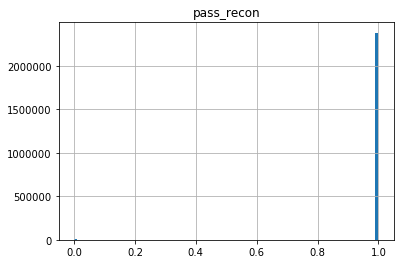

In [6]:
df_mc['D'].hist("pass_recon",bins=100)
plt.show()

In [16]:
help(root_pandas)

Help on module root_pandas:

NAME
    root_pandas

FUNCTIONS
    read_root(filename, treename=None, N=None)
    
    to_root(df, filename, treename)
        #create single-tree root file
    
    to_root_multi(filename, d)
        #create root file with multiple trees:
        # d is a map of tree name to data frames {"tree1":df1, "tree2":df2 ... etc}

FILE
    /home/sebouh/di-hadron/root_pandas.py




# Saving the MC file

In [ ]:
for target in ['Pb']:
    to_root(df_mc['%s'%target],'MC_Pairs_%s.root'%target, key='%s'%target)
    to_root(df_mc['%s_mix'%target],'MC_Pairs_%s.root'%target, key='%s_mix'%target,mode='a')
    to_root(df_mc['%s_trigger'%target],'MC_Pairs_%s.root'%target, key='%s_trigger'%target, mode='a')

In [ ]:
for kk in range(5):
    print('inside the loop',kk)
print('outside the loop',kk)    

In [ ]:
    for ievt  in range(mytree.GetEntries()):
        mytree.GetEntry(ievt)   
        particles = []  ## this is how you define a list in python, this is created for each event
        for i in range(len(mytree.pid)):
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i], mytree.Nphe[i], mytree.deltaZ[i], mytree.FidCheckCutPiPlus[i])     
            particles.append(i_part)
            if i_part.Zh > 0.4: #only save triggers and do correlations if they have z>0.4
                #tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                #for j in range(len(mytree.pid)): 
                #    if i==j: continue
                #    tupla['dphi'].append(dphi)
                #print(ievt,i,j)
                for mixparticle in ParticlesFromPrevious:
                    print('inside mixparticle loop')
                    #print(i,mixparticle, ParticlesFromPrevious)
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)

                    mixparticle.redefine(virtual_photon) #recalculates variables in this' event photon frame (not in the previous one)
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
        #print (' Exiting main loop over particles (i loop, not over all entries)')
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    return df, df_mix, df_trigger        
        
        
        

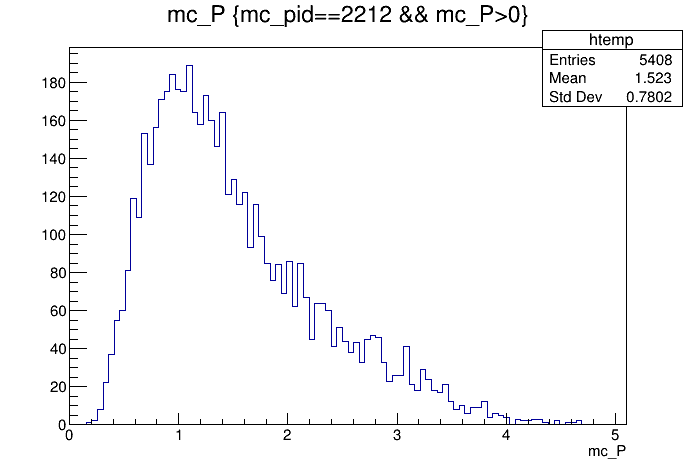

In [25]:
import ROOT
f=ROOT.TFile.Open('/home/sebouh/di-hadron/simul/Pb/9.root','READ')
t=f.Get("ntuple_sim")
c=ROOT.TCanvas()
t.Draw("mc_P", "mc_pid==2212 && mc_P>0", "", 10000)
c.Draw()

In [12]:
!ls -lth /home/sebouh/di-hadron/simul/D

total 24G
-rwxrwxr-x 1 sebouh sebouh 2.4G Aug 16  2023 9.root
-rwxrwxr-x 1 sebouh sebouh 2.7G Aug 16  2023 8.root
-rwxrwxr-x 1 sebouh sebouh 2.7G Aug 16  2023 7.root
-rwxrwxr-x 1 sebouh sebouh 2.6G Aug 16  2023 6.root
-rwxrwxr-x 1 sebouh sebouh 2.7G Aug 16  2023 5.root
-rwxrwxr-x 1 sebouh sebouh 2.7G Aug 16  2023 4.root
-rwxrwxr-x 1 sebouh sebouh 2.6G Aug 16  2023 3.root
-rwxrwxr-x 1 sebouh sebouh 2.8G Aug 16  2023 2.root
-rwxrwxr-x 1 sebouh sebouh 2.7G Aug 16  2023 1.root
